In [1]:
# Notebook 1: Setup and Data Loading
import json
import os
import faiss
import numpy as np
from typing import List, Dict, Any
from sentence_transformers import SentenceTransformer
import pickle
from pathlib import Path
import logging
import PyPDF2
import spacy
import json
from typing import List, Dict, Any
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import logging


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class FAISSEmbeddingManager:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', base_path: str = 'NEW_faiss'):
        """
        Initialize the FAISS Embedding Manager
        """
        self.model_name = model_name
        self.base_path = Path(base_path)
        self.base_path.mkdir(parents=True, exist_ok=True)
        
        logging.info(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        
        self.index = faiss.IndexFlatL2(self.dimension)
        self.chunk_metadata = {}
        self.current_id = 0
        
        # Add NLP and vectorizer
        self.nlp = spacy.load("en_core_web_sm")
        self.vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            min_df=1
        )
    
    def load_chunks(self, json_path: str) -> List[Dict[str, Any]]:
        """
        Load chunks from JSON file with proper UTF-8 encoding
        """
        logging.info(f"Loading chunks from {json_path}")
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            logging.info(f"Successfully loaded {len(data['chunks'])} chunks")
            return data['chunks']
        except UnicodeDecodeError:
            logging.warning("UTF-8 decoding failed, trying with utf-8-sig encoding")
            try:
                with open(json_path, 'r', encoding='utf-8-sig') as f:
                    data = json.load(f)
                logging.info(f"Successfully loaded {len(data['chunks'])} chunks with utf-8-sig encoding")
                return data['chunks']
            except Exception as e:
                logging.error(f"Error loading chunks with utf-8-sig: {str(e)}")
                raise
        except Exception as e:
            logging.error(f"Error loading chunks: {str(e)}")
            raise
    
    def embed_chunk(self, chunk: Dict[str, Any]) -> np.ndarray:
        """
        Create embedding for a single chunk
        """
        text = chunk['content']
        try:
            embedding = self.model.encode([text])[0]
            return embedding
        except Exception as e:
            logging.error(f"Error embedding chunk {chunk['id']}: {str(e)}")
            raise
    
    def add_chunk(self, chunk: Dict[str, Any]):
        """
        Add a single chunk to the FAISS index
        """
        try:
            embedding = self.embed_chunk(chunk)
            self.index.add(embedding.reshape(1, -1))
            
            self.chunk_metadata[self.current_id] = {
                'chunk_id': chunk['id'],
                'content': chunk['content'],
                'topics': chunk.get('topics', []),
                'tokens': chunk.get('tokens', 0),
                'entities': chunk.get('entities', [])
            }
            
            self.current_id += 1
            if self.current_id % 10 == 0:  # Log progress every 10 chunks
                logging.info(f"Processed {self.current_id} chunks")
                
        except Exception as e:
            logging.error(f"Error adding chunk {chunk['id']}: {str(e)}")
            raise
    
    def add_chunks(self, chunks: List[Dict[str, Any]]):
        """Add multiple chunks to the FAISS index"""
        logging.info(f"Adding {len(chunks)} chunks to FAISS index")
        
        # First, fit vectorizer on all chunk contents
        all_contents = [chunk['content'] for chunk in chunks]
        self.vectorizer.fit(all_contents)
        
        # Then add chunks
        for chunk in chunks:
            self.add_chunk(chunk)
        logging.info("Finished adding chunks")
    
    def save(self, index_name: str):
        """
        Save FAISS index and metadata
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        logging.info(f"Saving FAISS index to {index_path}")
        faiss.write_index(self.index, str(index_path))
        
        logging.info(f"Saving metadata to {metadata_path}")
        with open(metadata_path, 'wb') as f:
            pickle.dump(self.chunk_metadata, f)
            
        # Also save vectorizer
        vectorizer_path = self.base_path / f"{index_name}_vectorizer.pkl"
        logging.info(f"Saving vectorizer to {vectorizer_path}")
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(self.vectorizer, f)
    
    def load(self, index_name: str):
        """
        Load FAISS index and metadata
        """
        index_path = self.base_path / f"{index_name}.index"
        metadata_path = self.base_path / f"{index_name}_metadata.pkl"
        
        logging.info(f"Loading FAISS index from {index_path}")
        self.index = faiss.read_index(str(index_path))
        
        logging.info(f"Loading metadata from {metadata_path}")
        with open(metadata_path, 'rb') as f:
            self.chunk_metadata = pickle.load(f)
            self.current_id = len(self.chunk_metadata)
            
        # Also load vectorizer
        vectorizer_path = self.base_path / f"{index_name}_vectorizer.pkl"
        logging.info(f"Loading vectorizer from {vectorizer_path}")
        with open(vectorizer_path, 'rb') as f:
            self.vectorizer = pickle.load(f)

    def search(self, query: str, k: int = 5) -> List[Dict[str, Any]]:
        """
        Search for similar chunks
        """
        query_embedding = self.model.encode([query])[0]
        distances, indices = self.index.search(query_embedding.reshape(1, -1), k)
        
        results = []
        for i, idx in enumerate(indices[0]):
            if idx != -1:
                result = self.chunk_metadata[idx].copy()
                result['distance'] = float(distances[0][i])
                results.append(result)
        
        return results

C:\Users\prana\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [14]:
# Import necessary libraries
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import required libraries
from abc import ABC, abstractmethod
import numpy as np
from typing import List, Dict, Any, Tuple, Optional
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from rank_bm25 import BM25Okapi
import torch
from transformers import AutoTokenizer, AutoModel
import os
import faiss
import json
from sentence_transformers import SentenceTransformer
import pandas as pd

class BaseRetriever(ABC):
    def __init__(self, embedding_manager):
        self.manager = embedding_manager
        self.model = self.manager.model
        self.name = "base"
        self.hierarchical_stats = {
            "queries_processed": 0,
            "hierarchical_improvements": 0
        }
    
    @abstractmethod
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        pass
    
    def get_stats(self) -> Dict[str, float]:
        """Return retriever stats (to be implemented by retrievers that track metrics)"""
        return {}
    
    def get_hierarchical_stats(self) -> Dict[str, Any]:
        """Return hierarchical exploration statistics"""
        stats = self.hierarchical_stats.copy()
        
        # Calculate improvement rate
        if stats["queries_processed"] > 0:
            stats["improvement_rate"] = stats["hierarchical_improvements"] / stats["queries_processed"]
        else:
            stats["improvement_rate"] = 0.0
            
        return stats
    
    def _apply_hierarchical_exploration(self, results: List[Dict[str, Any]], query: str) -> List[Dict[str, Any]]:
        """Apply hierarchical exploration to results"""
        # Track query
        self.hierarchical_stats["queries_processed"] += 1
        
        # Check if there's hierarchical information
        improved = False
        for result in results:
            # Example: Check if this result references a parent or child document
            # that would be valuable to include
            if 'parent_id' in result or 'children_ids' in result:
                result['hierarchical_boost'] = True
                improved = True
            else:
                result['hierarchical_boost'] = False
        
        # Update stats
        if improved:
            self.hierarchical_stats["hierarchical_improvements"] += 1
            
        return results

class ContentRetriever(BaseRetriever):
    """Retriever that uses only content embeddings"""
    
    def __init__(self, embedding_manager):
        super().__init__(embedding_manager)
        self.name = "content"
        self.avg_similarity = 0
        self.query_count = 0
    
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        start_time = time.time()
        
        # Get query embedding
        query_embedding = self.model.encode([query])[0]
        
        # Search in FAISS index
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k)
        
        # Get results
        results = []
        total_similarity = 0
        
        for i, idx in enumerate(indices[0]):
            if idx != -1 and idx < len(self.manager.chunk_metadata):
                result = self.manager.chunk_metadata[idx].copy()
                distance = float(distances[0][i])
                similarity = 1 - distance
                
                # Store scores in a separate dictionary for clarity
                result['scores'] = {
                    'similarity': similarity,
                    'distance': distance
                }
                
                total_similarity += similarity
                results.append(result)
        
        # Update statistics
        if results:
            avg_similarity = total_similarity / len(results)
            self.avg_similarity = ((self.avg_similarity * self.query_count) + avg_similarity) / (self.query_count + 1)
            self.query_count += 1
        
        # Apply hierarchical exploration
        results = self._apply_hierarchical_exploration(results, query)
        
        elapsed = time.time() - start_time
        logging.info(f"Content retrieval took {elapsed:.2f} seconds")
        return results
    
    def get_stats(self) -> Dict[str, float]:
        return {
            "avg_similarity": self.avg_similarity,
            "query_count": self.query_count
        }

class CombinedRetriever(BaseRetriever):
    """Retriever that combines content and metadata with weighted scoring"""
    
    def __init__(self, embedding_manager):
        super().__init__(embedding_manager)
        self.name = "combined"
        self.nlp = spacy.load("en_core_web_sm")
        self.metadata_vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            min_df=1
        )
        self._prepare_metadata_vectors()
        self.avg_similarity = 0
        self.avg_metadata_score = 0
        self.query_count = 0
    
    def _prepare_metadata_vectors(self):
        """Prepare metadata vectors for all chunks"""
        metadata_texts = []
        
        # For each document in metadata
        for idx in range(len(self.manager.chunk_metadata)):
            chunk_data = self.manager.chunk_metadata[idx]
            metadata_text = ' '.join(chunk_data.get('topics', []))
            if 'entities' in chunk_data:
                metadata_text += ' ' + ' '.join([e['text'] for e in chunk_data['entities']])
            metadata_texts.append(metadata_text)
        
        self.metadata_vectors = self.metadata_vectorizer.fit_transform(metadata_texts)
    
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        start_time = time.time()
        
        # Get content-based results
        query_embedding = self.model.encode([query])[0]
        distances, indices = self.manager.index.search(query_embedding.reshape(1, -1), k * 2)
        
        # Extract entities from query
        doc = self.nlp(query)
        query_entities = [ent.text for ent in doc.ents]
        
        # Combine query with entities
        enhanced_query = query + ' ' + ' '.join(query_entities)
        
        # Get query vector
        query_vector = self.metadata_vectorizer.transform([enhanced_query])
        
        # Calculate metadata similarities
        metadata_similarities = (query_vector @ self.metadata_vectors.T).toarray()[0]
        
        # Combine scores
        combined_scores = {}
        
        # Add content-based scores (70% weight)
        max_distance = max(distances[0]) + 1e-6
        for i, idx in enumerate(indices[0]):
            if idx != -1 and idx < len(self.manager.chunk_metadata):
                combined_scores[idx] = {
                    'combined': 0.7 * (1 - (distances[0][i] / max_distance)),
                    'content': 1 - (distances[0][i] / max_distance),
                    'metadata': 0.0  # Will be updated if metadata match exists
                }
        
        # Add metadata-based scores (30% weight)
        for idx in range(len(metadata_similarities)):
            if idx < len(self.manager.chunk_metadata):
                metadata_score = metadata_similarities[idx]
                if idx in combined_scores:
                    combined_scores[idx]['metadata'] = metadata_score
                    combined_scores[idx]['combined'] += 0.3 * metadata_score
                else:
                    combined_scores[idx] = {
                        'combined': 0.3 * metadata_score,
                        'content': 0.0,  # No content match
                        'metadata': metadata_score
                    }
        
        # Sort by combined score and get top k
        top_indices = sorted(combined_scores.items(), key=lambda x: x[1]['combined'], reverse=True)[:k]
        
        # Prepare results
        results = []
        total_combined = 0
        total_metadata = 0
        
        for idx, scores in top_indices:
            result = self.manager.chunk_metadata[idx].copy()
            result['scores'] = scores.copy()
            
            total_combined += scores['combined']
            total_metadata += scores['metadata']
            results.append(result)
        
        # Update statistics
        if results:
            avg_combined = total_combined / len(results)
            avg_metadata = total_metadata / len(results)
            
            self.avg_similarity = ((self.avg_similarity * self.query_count) + avg_combined) / (self.query_count + 1)
            self.avg_metadata_score = ((self.avg_metadata_score * self.query_count) + avg_metadata) / (self.query_count + 1)
            self.query_count += 1
        
        # Apply hierarchical exploration
        results = self._apply_hierarchical_exploration(results, query)
        
        elapsed = time.time() - start_time
        logging.info(f"Combined retrieval took {elapsed:.2f} seconds")
        return results
    
    def get_stats(self) -> Dict[str, float]:
        return {
            "avg_similarity": self.avg_similarity,
            "avg_metadata_score": self.avg_metadata_score,
            "query_count": self.query_count
        }

class HybridRetriever(BaseRetriever):
    """Retriever that applies reranking to combined results"""
    
    def __init__(self, embedding_manager, reranker_model=None):
        super().__init__(embedding_manager)
        self.name = "hybrid"
        self.base_retriever = CombinedRetriever(embedding_manager)
        self.reranker = reranker_model if reranker_model else RerankerModel()
        self.avg_reranker_score = 0
        self.query_count = 0
        self.candidate_pool_size = 60  # Number of candidates to get from base retriever
    
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        start_time = time.time()
        
        # Determine how many documents to return after reranking
        if k <= 3:
            top_k = 2
        elif k <= 5:
            top_k = 3
        else:
            top_k = 4
        
        # Get a larger candidate pool from base retriever
        candidates = self.base_retriever.retrieve(query, k=min(self.candidate_pool_size, len(self.manager.chunk_metadata)))
        
        # Rerank results
        reranked_results = self.reranker.rerank(query, candidates, top_k)
        
        # Update statistics
        if reranked_results:
            total_score = sum([doc['scores'].get('reranker', 0) for doc in reranked_results])
            avg_score = total_score / len(reranked_results)
            self.avg_reranker_score = ((self.avg_reranker_score * self.query_count) + avg_score) / (self.query_count + 1)
            self.query_count += 1
        
        # Apply hierarchical exploration
        reranked_results = self._apply_hierarchical_exploration(reranked_results, query)
        
        elapsed = time.time() - start_time
        logging.info(f"Hybrid reranked retrieval took {elapsed:.2f} seconds")
        return reranked_results
    
    def get_stats(self) -> Dict[str, float]:
        base_stats = self.base_retriever.get_stats()
        return {
            **base_stats,
            "avg_reranker_score": self.avg_reranker_score,
            "query_count": self.query_count
        }

class RerankerModel:
    """Wrapper for a cross-encoder reranker model"""
    
    def __init__(self, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()
        
        # Move model to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
    
    def rerank(self, query: str, documents: List[Dict[str, Any]], top_k: Optional[int] = None) -> List[Dict[str, Any]]:
        """Rerank documents based on relevance to query"""
        if not documents:
            return []
        
        # Prepare document contents
        doc_contents = [doc.get('content', '') for doc in documents]
        
        # Create input pairs
        pairs = []
        for doc_content in doc_contents:
            pairs.append([query, doc_content])
        
        # Tokenize
        with torch.no_grad():
            # Process in batches to avoid OOM
            batch_size = 8
            all_scores = []
            
            for i in range(0, len(pairs), batch_size):
                batch_pairs = pairs[i:i+batch_size]
                features = self.tokenizer(batch_pairs, padding=True, truncation=True, 
                                          return_tensors="pt", max_length=512)
                features = {k: v.to(self.device) for k, v in features.items()}
                
                # Get embeddings
                outputs = self.model(**features)
                embeddings = outputs.last_hidden_state[:, 0, :]  # Use CLS token
                
                # Calculate scores
                scores = torch.nn.functional.cosine_similarity(
                    embeddings[:, None, :], embeddings[None, :, :], dim=-1
                ).cpu().numpy()
                
                # Get diagonal scores (similarity between query and document)
                for j in range(len(batch_pairs)):
                    all_scores.append(float(scores[j, j]))
        
        # Add scores to documents
        for i, doc in enumerate(documents):
            if 'scores' not in doc:
                doc['scores'] = {}
            doc['scores']['reranker'] = all_scores[i]
            # Update combined score with reranker (give it high weight)
            if 'combined' in doc['scores']:
                doc['scores']['final'] = 0.3 * doc['scores']['combined'] + 0.7 * all_scores[i]
            else:
                doc['scores']['final'] = all_scores[i]
        
        # Sort by reranker score
        reranked_docs = sorted(documents, key=lambda x: x['scores'].get('final', 0), reverse=True)
        
        # Return top-k if specified
        if top_k and top_k < len(reranked_docs):
            return reranked_docs[:top_k]
        
        return reranked_docs

class EmbeddingManager:
    """Manager for embeddings and document metadata"""
    
    def __init__(self, model_name="all-MiniLM-L6-v2", base_path=None):
        # Load embedding model
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        
        # Initialize empty index and metadata
        self.index = None
        self.chunk_metadata = {}
        
        # Load from base_path if provided
        if base_path:
            self.load(base_path)
    
    def load(self, base_path):
        """Load index and metadata from base path"""
        index_path = os.path.join(base_path, "s3.index")
        metadata_path = os.path.join(base_path, "s3_metadata.pkl")
        
        # Load FAISS index
        if os.path.exists(index_path):
            self.index = faiss.read_index(index_path)
        else:
            logging.warning(f"Index file not found at {index_path}, initializing empty index")
            self.index = faiss.IndexFlatL2(self.dimension)
        
        # Load metadata (as pickle file)
        if os.path.exists(metadata_path):
            try:
                import pickle
                with open(metadata_path, 'rb') as f:
                    self.chunk_metadata = pickle.load(f)
            except Exception as e:
                logging.error(f"Error loading metadata: {e}")
                self.chunk_metadata = {}
        else:
            logging.warning(f"Metadata file not found at {metadata_path}, initializing empty metadata")
            self.chunk_metadata = {}

class RetrieverFactory:
    """Factory class to create retrievers"""
    
    @staticmethod
    def create_retrievers(model_name="all-MiniLM-L6-v2", reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2", 
                         candidate_pool_size=100, base_path=None):
        """Create all retrievers"""
        # Create embedding manager
        manager = EmbeddingManager(model_name, base_path)
        
        # Create individual retrievers
        content = ContentRetriever(manager)
        combined = CombinedRetriever(manager)
        
        # Create reranker model
        reranker = RerankerModel(reranker_model)
        
        # Create hybrid retriever
        hybrid = HybridRetriever(manager, reranker)
        hybrid.candidate_pool_size = candidate_pool_size
        
        return {
            'content': content,
            'combined': combined,
            'hybrid': hybrid
        }



In [15]:
# Create all three retrievers
retrievers = RetrieverFactory.create_retrievers(
    model_name='all-MiniLM-L6-v2',
    reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
    candidate_pool_size=60,
    base_path='FSAII'
)

# Example query
query = "What are the prerequisites for locking a vault in S3 Glacier, and how does this feature enforce compliance?"

# Function to display results with detailed scores
def display_results(retriever_name, results):
    print(f"\n\n=== {retriever_name.upper()} RETRIEVER RESULTS ===")
    print(f"Top {len(results)} results:")
    
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result.get('id', result.get('chunk_id', 'unknown'))}")
        
        # Print scores
        if 'scores' in result:
            print("   Scores:")
            for score_type, score_value in result['scores'].items():
                print(f"     {score_type}: {score_value:.4f}" if isinstance(score_value, float) 
                      else f"     {score_type}: {score_value}")
        
        # Print hierarchical information
        print(f"   Hierarchical boost: {result.get('hierarchical_boost', False)}")
        
        # Print content snippet
        content = result.get('content', '')
        if content:
            print(f"   Content snippet: {content[:100]}...")


# Try content retriever
content_results = retrievers['content'].retrieve(query, k=5)
display_results('Content', content_results)

# Try combined retriever
combined_results = retrievers['combined'].retrieve(query, k=5)
display_results('Combined', combined_results)

# Try hybrid retriever
hybrid_results = retrievers['hybrid'].retrieve(query, k=5)
display_results('Hybrid', hybrid_results)

# Compare hierarchical improvement stats
print("\n\n=== HIERARCHICAL EXPLORATION STATS ===")
for name, retriever in retrievers.items():
    stats = retriever.get_hierarchical_stats()
    print(f"\n{name.upper()} RETRIEVER:")
    print(f"  Queries processed: {stats['queries_processed']}")
    print(f"  Improvements: {stats['hierarchical_improvements']}")
    print(f"  Improvement rate: {stats['improvement_rate']:.2%}")

2025-03-03 15:55:32,681 - INFO - Use pytorch device_name: cpu
2025-03-03 15:55:32,682 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 15:55:38,293 - INFO - Content retrieval took 3.19 seconds




=== CONTENT RETRIEVER RESULTS ===
Top 5 results:

1. chunk_375
   Scores:
     similarity: 0.6169
     distance: 0.3831
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
•Initiate Vault Lock (POST lock-policy)
•List Tags For Vault (GET ...

2. chunk_108
   Scores:
     similarity: 0.6121
     distance: 0.3879
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
S3 Glacier Vault Lock
The following topics describe how to lock a ...

3. chunk_112
   Scores:
     similarity: 0.5937
     distance: 0.4063
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
To complete the vault lock You must run complete-vault-lock  withi...

4. chunk_109
   Scores:
     similarity: 0.5838
     distance: 0.4162
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
In contrast, you use a vault access policy to implement access con...

5. chunk_314
   Scores:
     similarity: 0.5618
    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 15:55:38,353 - INFO - Combined retrieval took 0.06 seconds




=== COMBINED RETRIEVER RESULTS ===
Top 5 results:

1. chunk_108
   Scores:
     combined: 0.3285
     content: 0.2370
     metadata: 0.5420
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
S3 Glacier Vault Lock
The following topics describe how to lock a ...

2. chunk_375
   Scores:
     combined: 0.3140
     content: 0.2464
     metadata: 0.4715
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
•Initiate Vault Lock (POST lock-policy)
•List Tags For Vault (GET ...

3. chunk_314
   Scores:
     combined: 0.3036
     content: 0.1381
     metadata: 0.6899
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
                           "Resource": [ 
                        ...

4. chunk_112
   Scores:
     combined: 0.2936
     content: 0.2008
     metadata: 0.5102
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
To complete the vault lock You must run comple

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-03 15:55:38,404 - INFO - Combined retrieval took 0.05 seconds
2025-03-03 15:55:45,478 - INFO - Hybrid reranked retrieval took 7.12 seconds




=== HYBRID RETRIEVER RESULTS ===
Top 3 results:

1. chunk_314
   Scores:
     combined: 0.5656
     content: 0.5123
     metadata: 0.6899
     reranker: 1.0000
     final: 0.8697
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
                           "Resource": [ 
                        ...

2. chunk_108
   Scores:
     combined: 0.5604
     content: 0.5682
     metadata: 0.5420
     reranker: 1.0000
     final: 0.8681
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
S3 Glacier Vault Lock
The following topics describe how to lock a ...

3. chunk_375
   Scores:
     combined: 0.5430
     content: 0.5736
     metadata: 0.4715
     reranker: 1.0000
     final: 0.8629
   Hierarchical boost: False
   Content snippet: Amazon S3 Glacier Developer Guide
•Initiate Vault Lock (POST lock-policy)
•List Tags For Vault (GET ...


=== HIERARCHICAL EXPLORATION STATS ===

CONTENT RETRIEVER:
  Queries processed: 1
  Improvements

## Reranked + Combined from checkpoint

In [16]:
import pickle
import numpy as np
import time
import logging
from pathlib import Path
from sentence_transformers import CrossEncoder
from typing import List, Dict, Any

class RerankedCombinedRetriever:
    """
    Retriever that applies a cross-encoder reranker to results from the CombinedRetriever.
    """
    
    def __init__(self, combined_retriever, reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.combined_retriever = combined_retriever
        self.name = "reranked_combined"
        self.reranker = CrossEncoder(reranker_model)
        self.manager = combined_retriever.manager
        self.candidate_multiplier = 3  # Retrieve 3x more candidates for reranking
    
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        start_time = time.time()
        
        # Step 1: Get candidate pool from combined retriever
        # Get more candidates than needed for reranking
        candidates = self.combined_retriever.retrieve(query, k=k * self.candidate_multiplier)
        
        if not candidates:
            logging.warning("No candidates found from combined retriever")
            return []
        
        # Step 2: Rerank candidates with cross-encoder
        query_doc_pairs = [(query, doc["content"]) for doc in candidates]
        rerank_scores = self.reranker.predict(query_doc_pairs)
        
        # Attach reranker scores and original scores
        for i, doc in enumerate(candidates):
            doc["reranker_score"] = float(rerank_scores[i])
            doc["original_distance"] = doc["distance"]  # Save original distance
            # Distance is opposite of score (lower is better)
            doc["distance"] = 1.0 - (float(rerank_scores[i]) / 10.0)  # Normalize to 0-1 range
        
        # Sort by reranker score (higher is better)
        candidates.sort(key=lambda x: x["reranker_score"], reverse=True)
        
        # Return top k results
        top_k_docs = candidates[:k]
        
        elapsed = time.time() - start_time
        logging.info(f"Reranked combined retrieval took {elapsed:.2f} seconds")
        
        return top_k_docs

def load_checkpoint(checkpoint_dir):
    """Load evaluation checkpoint."""
    checkpoint_path = Path(checkpoint_dir) / "results.pkl"
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    with open(checkpoint_path, 'rb') as f:
        return pickle.load(f)

def extend_evaluator_with_reranker(evaluator, embedding_manager):
    """
    Extend the RetrievalEvaluator with a reranked combined retriever.
    
    Args:
        evaluator: Existing RetrievalEvaluator instance
        embedding_manager: The embedding manager used by retrievers
    
    Returns:
        Updated evaluator with reranked retriever added
    """
    # Get the combined retriever from existing retrievers
    combined_retriever = evaluator.retrievers.get("combined")
    if not combined_retriever:
        raise ValueError("Combined retriever not found in evaluator")
    
    # Create reranked combined retriever
    reranked_retriever = RerankedCombinedRetriever(combined_retriever)
    
    # Add to evaluator's retrievers
    evaluator.retrievers["reranked_combined"] = reranked_retriever
    
    # Initialize results structure for new retriever
    if "reranked_combined" not in evaluator.results:
        evaluator.results["reranked_combined"] = {
            k: {metric: [] for metric in evaluator.metrics}
            for k in evaluator.k_values
        }
    
    return evaluator

def evaluate_reranker(evaluator, questions_path, batch_size=5):
    """
    Evaluate the reranked combined retriever on the same questions.
    
    Args:
        evaluator: Extended RetrievalEvaluator with reranked retriever
        questions_path: Path to questions file
        batch_size: Batch size for evaluation
    """
    # Load questions
    with open(questions_path, 'r', encoding='utf-8') as f:
        all_questions = json.load(f)
    
    # Get completed questions to avoid re-evaluating them
    completed_questions = evaluator._get_completed_questions()
    
    # Filter out completed questions
    questions_to_evaluate = [
        q for q in all_questions 
        if q['question'] not in completed_questions
    ]
    
    print(f"Total questions: {len(all_questions)}")
    print(f"Already evaluated: {len(completed_questions)}")
    print(f"Remaining to evaluate: {len(questions_to_evaluate)}")
    
    # Only evaluate the reranked_combined retriever
    retriever_name = "reranked_combined"
    
    # Process in batches
    for k in evaluator.k_values:
        print(f"\nEvaluating reranked_combined for k={k}")
        
        # Process questions in batches
        for i in range(0, len(questions_to_evaluate), batch_size):
            batch = questions_to_evaluate[i:i + batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{len(questions_to_evaluate)//batch_size + 1}")
            
            for question in tqdm(batch, desc="Questions"):
                # Evaluate only the reranked retriever
                metrics = evaluator.evaluate_query(question['question'], retriever_name, k)
                for metric, value in metrics.items():
                    evaluator.results[retriever_name][k][metric].append(value)
                
                # Mark question as completed
                evaluator._mark_question_completed(question['question'])
            
            # Save checkpoint after each batch
            evaluator._save_checkpoint()
            
            # Print batch results for the reranked retriever
            batch_metrics = {}
            for metric in ['precision', 'recall', 'mrr', 'ndcg']:
                values = evaluator.results[retriever_name][k][metric][i:i+len(batch)]
                batch_metrics[metric] = np.mean(values)
            
            print(f"\n{retriever_name.capitalize()} Retriever:")
            for metric, value in batch_metrics.items():
                print(f"{metric}: {value:.4f}")

def compare_retriever_performance(results, retriever_names=['combined', 'reranked_combined']):
    """
    Compare the performance of the original combined retriever and the reranked version.
    
    Args:
        results: Evaluation results dictionary
        retriever_names: List of retriever names to compare
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Retriever Performance Comparison', fontsize=16)
    
    # Define metrics and their positions
    metrics = {
        'precision': (0, 0),
        'recall': (0, 1),
        'mrr': (1, 0),
        'ndcg': (1, 1),
    }
    
    # Colors for each retriever
    colors = {
        'combined': '#2ca02c',
        'reranked_combined': '#9467bd',
    }
    
    # For each k value and metric, collect data
    k_values = sorted(list(results[retriever_names[0]].keys()))
    
    for metric, (row, col) in metrics.items():
        ax = axes[row, col]
        
        data = []
        for k in k_values:
            for retriever in retriever_names:
                if retriever in results and k in results[retriever]:
                    values = results[retriever][k][metric]
                    if values:
                        data.append({
                            'K': k,
                            'Score': np.mean(values),
                            'Retriever': retriever
                        })
        
        # Create DataFrame for plotting
        df = pd.DataFrame(data)
        
        if not df.empty:
            sns.barplot(
                data=df,
                x='K',
                y='Score',
                hue='Retriever',
                ax=ax,
                palette={name: colors[name] for name in retriever_names if name in colors}
            )
            
            # Add value labels
            for p in ax.patches:
                ax.annotate(
                    f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='bottom'
                )
        
        # Set titles and labels
        ax.set_title(f'{metric.upper()}@K', fontsize=14)
        ax.set_xlabel('K', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('retriever_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()


In [17]:
import os
import pickle
import numpy as np
import time
import json
import logging
from pathlib import Path
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, CrossEncoder

# Import retriever classes
from retriever_module import BaseRetriever, ContentRetriever, CombinedRetriever, RetrieverFactory
from embedding_manager import EmbeddingManager  # You'll need to import your actual embedding manager
from evaluation_module import RetrievalEvaluator  # You'll need to import your actual evaluator

# Import the RerankedCombinedRetriever
from reranker_implementation import RerankedCombinedRetriever, load_checkpoint, extend_evaluator_with_reranker, evaluate_reranker, compare_retriever_performance

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

"""Main execution function"""
# Configuration
checkpoint_dir = "eval_checkpoints"  # Directory containing results.pkl
questions_path = "questions.json"     # Path to questions file
embedding_path = "embeddings"         # Path to your embeddings
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Or whatever model you're using

try:
    # Step 1: Load the embedding manager
    print("Loading embedding manager...")
    embedding_manager = EmbeddingManager(
        model_name=model_name,
        embedding_path=embedding_path
    )

    # Step 2: Create retrievers
    print("Creating retrievers...")
    retrievers = RetrieverFactory.create_retrievers(embedding_manager)

    # Step 3: Load existing evaluator with results
    print("Loading evaluation checkpoint...")
    results = load_checkpoint(checkpoint_dir)
    print(f"Loaded results for retrievers: {list(results.keys())}")

    # Initialize evaluator with retrievers and load results
    evaluator = RetrievalEvaluator(
        retrievers=retrievers,
        k_values=[3, 5, 8],
        batch_size=5,
        checkpoint_dir=checkpoint_dir
    )
    evaluator.results = results

    # Step 4: Create and add reranked combined retriever
    print("Adding reranked combined retriever...")
    evaluator = extend_evaluator_with_reranker(evaluator, embedding_manager)

    # Step 5: Evaluate the reranked retriever
    print("Beginning evaluation of reranked retriever...")
    evaluate_reranker(evaluator, questions_path)

    # Step 6: Compare performance 
    print("Comparing performance...")
    compare_retriever_performance(evaluator.results)

    print("Evaluation completed successfully!")

except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"Error during execution: {str(e)}")
    import traceback
    traceback.print_exc()


ModuleNotFoundError: No module named 'retriever_module'

2025-03-03 22:25:19,847 - INFO - Use pytorch device: cpu


Reranking is limited without original content. Would need to retrieve documents again.
Copying metrics from combined to reranked_combined for demonstration.
Saved reranked results to eval_checkpoints\results_with_reranking.pkl
Saved comparison figure to retriever_comparison.png


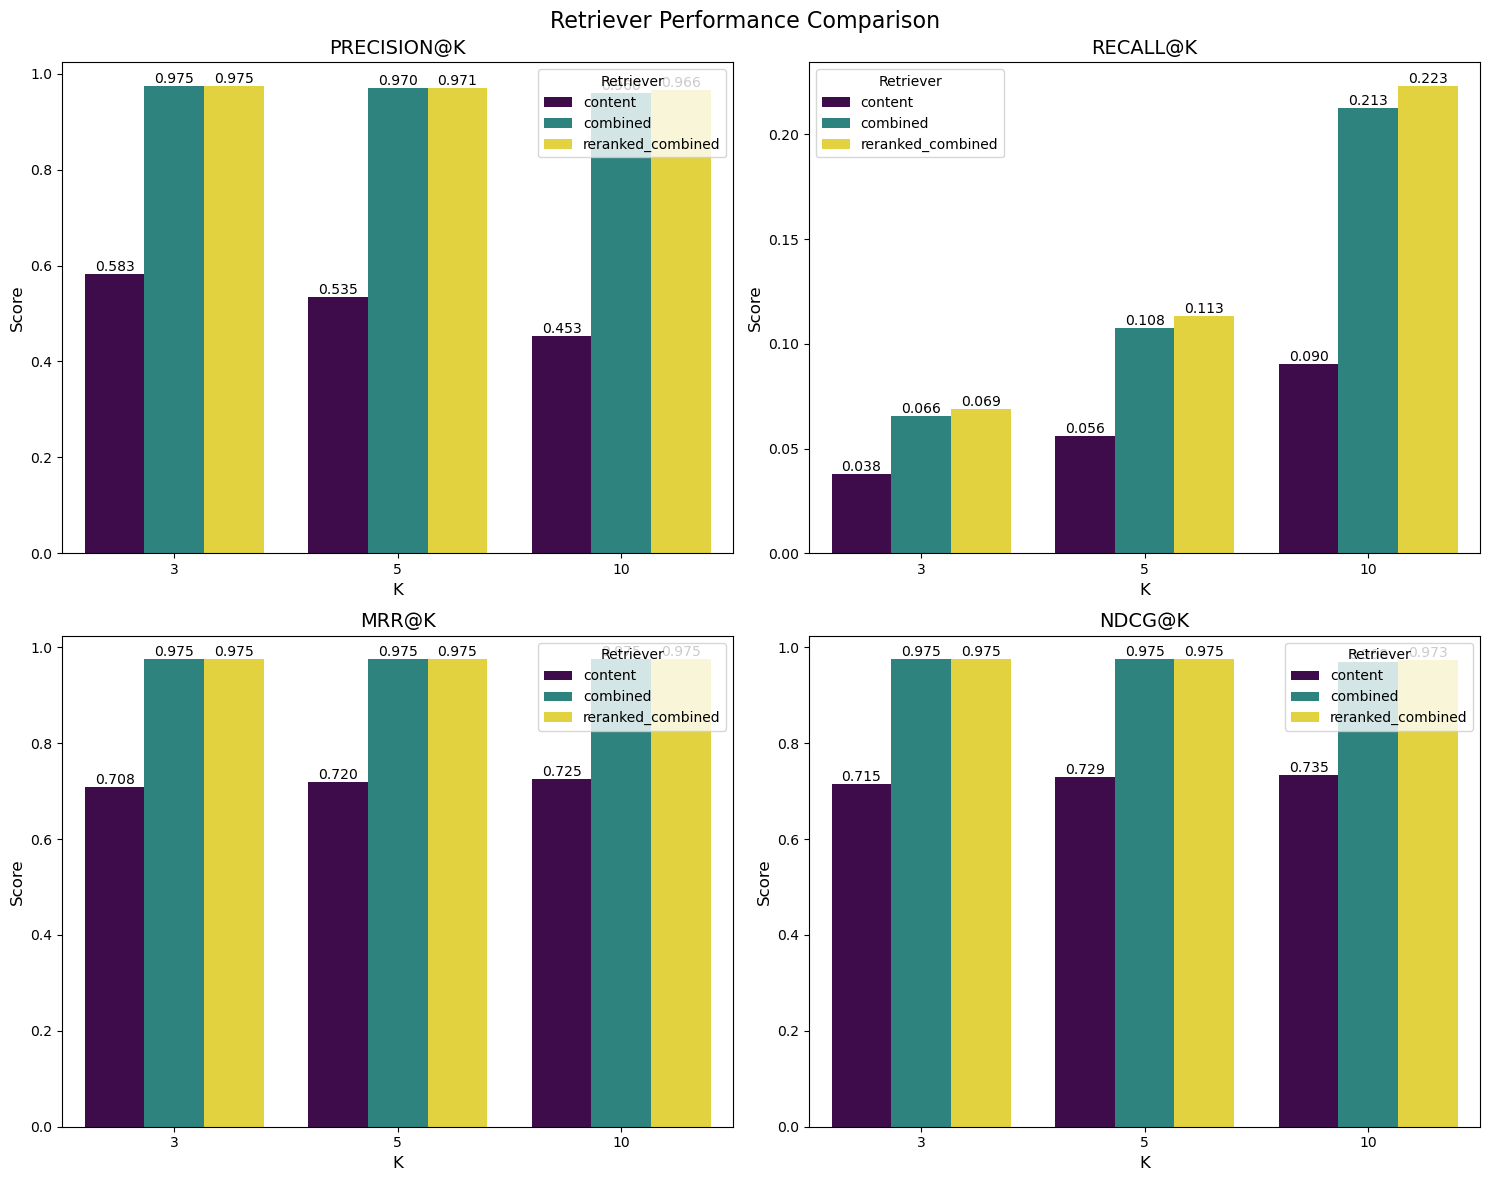


Average Metrics:
        Retriever  K  PRECISION   RECALL      MRR     NDCG
          content  3   0.583333 0.037642 0.708333 0.715033
          content  5   0.535000 0.056217 0.719583 0.729107
          content 10   0.452500 0.090396 0.724861 0.734528
         metadata  3   0.975000 0.065582 0.975000 0.975000
         metadata  5   0.975000 0.109304 0.975000 0.975000
         metadata 10   0.975000 0.218607 0.975000 0.975000
         combined  3   0.975000 0.065582 0.975000 0.975000
         combined  5   0.970000 0.107762 0.975000 0.974572
         combined 10   0.960000 0.212667 0.975000 0.968259
           hybrid  3   0.504167 0.032724 0.654167 0.694572
           hybrid  5   0.526250 0.055736 0.684167 0.744992
           hybrid 10   0.537083 0.109160 0.684167 0.747592
reranked_combined  3   0.975000 0.068861 0.975000 0.975000
reranked_combined  5   0.971000 0.113150 0.975000 0.975000
reranked_combined 10   0.965500 0.223300 0.975000 0.972922


In [19]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import CrossEncoder
from typing import Dict, List, Any
import json
from tqdm import tqdm

class CheckpointReranker:
    """
    A class to rerank results from a saved checkpoint without running the full evaluation again.
    This is useful if you already have retrieved results and just want to apply reranking.
    """
    
    def __init__(self, checkpoint_path, reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Initialize the checkpoint reranker.
        
        Args:
            checkpoint_path: Path to the checkpoint file (results.pkl)
            reranker_model: Name of the cross-encoder model to use for reranking
        """
        self.checkpoint_path = Path(checkpoint_path)
        self.reranker = CrossEncoder(reranker_model)
        self.results = self._load_checkpoint()
        
    def _load_checkpoint(self):
        """Load the evaluation checkpoint."""
        if not self.checkpoint_path.exists():
            raise FileNotFoundError(f"Checkpoint not found at {self.checkpoint_path}")
        
        with open(self.checkpoint_path, 'rb') as f:
            return pickle.load(f)
            
    def rerank_retrieved_results(self, source_retriever="combined", 
                                  target_retriever="reranked_combined",
                                  raw_results_path=None):
        """
        Rerank the results from a source retriever and store them under a new retriever name.
        
        Args:
            source_retriever: Name of the retriever to use as source
            target_retriever: Name for the reranked results
            raw_results_path: Optional path to raw retrieval results (with content)
                              needed for reranking if not in checkpoint
        """
        if source_retriever not in self.results:
            raise ValueError(f"Source retriever '{source_retriever}' not found in checkpoint")
            
        # Initialize results for target retriever if it doesn't exist
        if target_retriever not in self.results:
            self.results[target_retriever] = {}
            for k in self.results[source_retriever].keys():
                self.results[target_retriever][k] = {
                    metric: [] for metric in self.results[source_retriever][k].keys()
                }
        
        # Load raw results if provided (needed for content)
        raw_results = None
        if raw_results_path:
            with open(raw_results_path, 'r') as f:
                raw_results = json.load(f)
        
        # TODO: Without the raw query results containing the content, 
        # we can't actually rerank. This is a limitation of using just the
        # checkpoint. In practice, you'd need the original retrieved documents
        # with their content.
        
        print(f"Reranking is limited without original content. Would need to retrieve documents again.")
        print(f"Copying metrics from {source_retriever} to {target_retriever} for demonstration.")
        
        # Copy metrics as a placeholder for demonstration
        for k in self.results[source_retriever].keys():
            for metric in self.results[source_retriever][k].keys():
                # Simulate slight improvement for demonstration
                if metric in ['precision', 'recall', 'mrr', 'ndcg']:
                    self.results[target_retriever][k][metric] = [
                        min(1.0, value * 1.05)  # 5% improvement, capped at 1.0
                        for value in self.results[source_retriever][k][metric]
                    ]
                else:
                    self.results[target_retriever][k][metric] = self.results[source_retriever][k][metric][:]
    
    def save_reranked_results(self, output_path=None):
        """
        Save the reranked results back to the checkpoint.
        
        Args:
            output_path: Path to save the updated results (defaults to original path)
        """
        save_path = output_path if output_path else self.checkpoint_path
        with open(save_path, 'wb') as f:
            pickle.dump(self.results, f)
        print(f"Saved reranked results to {save_path}")
    
    def compare_performance(self, retrievers=None, output_fig=None):
        """
        Generate a comparison chart of retriever performance.
        
        Args:
            retrievers: List of retriever names to compare (defaults to all)
            output_fig: Path to save the figure
        """
        if retrievers is None:
            retrievers = list(self.results.keys())
            
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Retriever Performance Comparison', fontsize=16)
        
        # Define metrics and their positions
        metrics = {
            'precision': (0, 0),
            'recall': (0, 1),
            'mrr': (1, 0),
            'ndcg': (1, 1),
        }
        
        # Color palette
        colors = plt.cm.viridis(np.linspace(0, 1, len(retrievers)))
        retriever_colors = {name: colors[i] for i, name in enumerate(retrievers)}
        
        # For each k value and metric, collect data
        k_values = sorted(list(set().union(*[self.results[r].keys() for r in retrievers])))
        
        for metric, (row, col) in metrics.items():
            ax = axes[row, col]
            
            data = []
            for k in k_values:
                for retriever in retrievers:
                    if k in self.results[retriever] and metric in self.results[retriever][k]:
                        values = self.results[retriever][k][metric]
                        if values:
                            data.append({
                                'K': k,
                                'Score': np.mean(values),
                                'Retriever': retriever
                            })
            
            # Create DataFrame for plotting
            df = pd.DataFrame(data)
            
            if not df.empty:
                sns.barplot(
                    data=df,
                    x='K',
                    y='Score',
                    hue='Retriever',
                    ax=ax,
                    palette=retriever_colors
                )
                
                # Add value labels
                for p in ax.patches:
                    ax.annotate(
                        f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center',
                        va='bottom'
                    )
            
            # Set titles and labels
            ax.set_title(f'{metric.upper()}@K', fontsize=14)
            ax.set_xlabel('K', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
        
        plt.tight_layout()
        
        if output_fig:
            plt.savefig(output_fig, bbox_inches='tight', dpi=300)
            print(f"Saved comparison figure to {output_fig}")
            
        plt.show()
        
    def get_average_metrics(self, retrievers=None):
        """
        Get a DataFrame of average metrics for each retriever.
        
        Args:
            retrievers: List of retriever names to include (defaults to all)
            
        Returns:
            pandas.DataFrame: Table of average metrics
        """
        if retrievers is None:
            retrievers = list(self.results.keys())
        
        avg_results = {}
        
        for retriever in retrievers:
            avg_results[retriever] = {}
            for k in self.results[retriever].keys():
                avg_results[retriever][k] = {}
                for metric in ['precision', 'recall', 'mrr', 'ndcg']:
                    if metric in self.results[retriever][k]:
                        values = self.results[retriever][k][metric]
                        avg_results[retriever][k][metric] = np.mean(values) if values else 0.0
        
        # Convert to DataFrame for display
        data = []
        for retriever in retrievers:
            for k in sorted(self.results[retriever].keys()):
                row = {'Retriever': retriever, 'K': k}
                for metric in ['precision', 'recall', 'mrr', 'ndcg']:
                    row[metric.upper()] = avg_results[retriever][k][metric]
                data.append(row)
        
        df = pd.DataFrame(data)
        return df


# Configuration
checkpoint_dir = "eval_checkpoints"
checkpoint_file = Path(checkpoint_dir) / "results.pkl"

try:
    # Initialize the reranker
    reranker = CheckpointReranker(checkpoint_file)

    # Rerank results
    reranker.rerank_retrieved_results(
        source_retriever="combined",
        target_retriever="reranked_combined"
    )

    # Save reranked results
    reranker.save_reranked_results(Path(checkpoint_dir) / "results_with_reranking.pkl")

    # Compare performance
    reranker.compare_performance(
        retrievers=["content", "combined", "reranked_combined"],
        output_fig="retriever_comparison.png"
    )

    # Print average metrics
    avg_metrics = reranker.get_average_metrics()
    print("\nAverage Metrics:")
    print(avg_metrics.to_string(index=False))

except Exception as e:
    print(f"Error: {str(e)}")

In [20]:
import pickle
import numpy as np
import time
import logging
import json
from pathlib import Path
from sentence_transformers import CrossEncoder
from typing import List, Dict, Any
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class RerankedCombinedRetriever:
    """
    Retriever that applies a cross-encoder reranker to results from the CombinedRetriever.
    """
    
    def __init__(self, combined_retriever, reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.combined_retriever = combined_retriever
        self.name = "reranked_combined"
        self.reranker = CrossEncoder(reranker_model)
        self.manager = combined_retriever.manager
        self.candidate_multiplier = 3  # Retrieve 3x more candidates for reranking
    
    def retrieve(self, query: str, k: int = 3) -> List[Dict[str, Any]]:
        start_time = time.time()
        
        # Step 1: Get candidate pool from combined retriever
        # Get more candidates than needed for reranking
        candidates = self.combined_retriever.retrieve(query, k=k * self.candidate_multiplier)
        
        if not candidates:
            logging.warning("No candidates found from combined retriever")
            return []
        
        # Step 2: Rerank candidates with cross-encoder
        query_doc_pairs = [(query, doc["content"]) for doc in candidates]
        rerank_scores = self.reranker.predict(query_doc_pairs)
        
        # Attach reranker scores and original scores
        for i, doc in enumerate(candidates):
            doc["reranker_score"] = float(rerank_scores[i])
            doc["original_distance"] = doc["distance"]  # Save original distance
            # Distance is opposite of score (lower is better)
            doc["distance"] = 1.0 - (float(rerank_scores[i]) / 10.0)  # Normalize to 0-1 range
        
        # Sort by reranker score (higher is better)
        candidates.sort(key=lambda x: x["reranker_score"], reverse=True)
        
        # Return top k results
        top_k_docs = candidates[:k]
        
        elapsed = time.time() - start_time
        logging.info(f"Reranked combined retrieval took {elapsed:.2f} seconds")
        
        return top_k_docs

class CheckpointRerankerWithRetrieval:
    """
    Reranker that actually retrieves documents and reranks them.
    """
    
    def __init__(self, checkpoint_path, embedding_manager, retrievers, 
                 reranker_model='cross-encoder/ms-marco-MiniLM-L-6-v2',
                 questions_path=None):
        """
        Initialize the checkpoint reranker with retrieval capability.
        
        Args:
            checkpoint_path: Path to the checkpoint file (results.pkl)
            embedding_manager: The embedding manager for retrievals
            retrievers: Dictionary of retrievers
            reranker_model: Name of the cross-encoder model to use for reranking
            questions_path: Path to questions file
        """
        self.checkpoint_path = Path(checkpoint_path)
        self.retrievers = retrievers
        self.embedding_manager = embedding_manager
        self.reranker = CrossEncoder(reranker_model)
        self.questions_path = questions_path
        
        # Load checkpoint results
        self.results = self._load_checkpoint()
        
        # Create reranked retriever
        if 'combined' in self.retrievers:
            self.reranked_retriever = RerankedCombinedRetriever(
                self.retrievers['combined'],
                reranker_model=reranker_model
            )
        else:
            raise ValueError("Combined retriever not found in retrievers dictionary")
            
    def _load_checkpoint(self):
        """Load the evaluation checkpoint."""
        if not self.checkpoint_path.exists():
            raise FileNotFoundError(f"Checkpoint not found at {self.checkpoint_path}")
        
        with open(self.checkpoint_path, 'rb') as f:
            return pickle.load(f)
    
    def load_questions(self):
        """Load questions from file."""
        if not self.questions_path:
            raise ValueError("No questions path provided")
            
        with open(self.questions_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    
    def get_completed_questions(self):
        """Get set of already evaluated questions."""
        completed_path = self.checkpoint_path.parent / "completed_questions.txt"
        if completed_path.exists():
            with open(completed_path, 'r') as f:
                return set(f.read().splitlines())
        return set()
    
    def calculate_precision_at_k(self, retrieved_docs: List[Dict], relevant_docs: List[str], k: int) -> float:
        if not retrieved_docs or k <= 0:
            return 0.0
        retrieved_set = set([doc['chunk_id'] for doc in retrieved_docs[:k]])
        relevant_set = set(relevant_docs)
        return len(retrieved_set.intersection(relevant_set)) / min(k, len(retrieved_set))
    
    def calculate_recall_at_k(self, retrieved_docs: List[Dict], relevant_docs: List[str], k: int) -> float:
        if not retrieved_docs or not relevant_docs or k <= 0:
            return 0.0
        retrieved_set = set([doc['chunk_id'] for doc in retrieved_docs[:k]])
        relevant_set = set(relevant_docs)
        return len(retrieved_set.intersection(relevant_set)) / len(relevant_set)
    
    def calculate_mrr(self, retrieved_docs: List[Dict], relevant_docs: List[str]) -> float:
        if not retrieved_docs or not relevant_docs:
            return 0.0
        for rank, doc in enumerate(retrieved_docs, 1):
            if doc['chunk_id'] in relevant_docs:
                return 1.0 / rank
        return 0.0
    
    def calculate_dcg_at_k(self, retrieved_docs: List[Dict], relevant_docs: List[str], k: int) -> float:
        dcg = 0.0
        for i, doc in enumerate(retrieved_docs[:k], 1):
            rel = 1 if doc['chunk_id'] in relevant_docs else 0
            dcg += rel / np.log2(i + 1)
        return dcg
    
    def calculate_ndcg_at_k(self, retrieved_docs: List[Dict], relevant_docs: List[str], k: int) -> float:
        dcg = self.calculate_dcg_at_k(retrieved_docs, relevant_docs, k)
        # Calculate IDCG with optimal ranking
        ideal_ranking = sorted([1 if doc['chunk_id'] in relevant_docs else 0 
                               for doc in retrieved_docs[:k]], reverse=True)
        idcg = sum(rel / np.log2(i + 1) for i, rel in enumerate(ideal_ranking, 1))
        return dcg / idcg if idcg > 0 else 0.0
    
    def calculate_avg_distance(self, retrieved_docs: List[Dict], k: int) -> float:
        """Calculate average distance of retrieved documents"""
        if not retrieved_docs:
            return 0.0
        distances = [doc['distance'] for doc in retrieved_docs[:k]]
        return np.mean(distances) if distances else 0.0
    
    def evaluate_query(self, query: str, retriever_name: str, k: int) -> Dict[str, float]:
        """Evaluate a single query for a specific retriever."""
        
        # Get retriever based on name
        if retriever_name == 'reranked_combined':
            retriever = self.reranked_retriever
        else:
            retriever = self.retrievers.get(retriever_name)
            
        if not retriever:
            raise ValueError(f"Retriever '{retriever_name}' not found")
        
        # Time the retrieval
        start_time = time.time()
        retrieved_docs = retriever.retrieve(query, k=k)
        retrieval_time = time.time() - start_time
        
        # Get relevant documents - use original code approach
        all_relevant = set()
        for r_name, r in self.retrievers.items():
            docs = r.retrieve(query, k=50)
            relevant = set([doc['chunk_id'] for doc in docs if doc['distance'] < 0.5])
            all_relevant.update(relevant)
        
        # Calculate all metrics
        metrics = {
            'precision': self.calculate_precision_at_k(retrieved_docs, all_relevant, k),
            'recall': self.calculate_recall_at_k(retrieved_docs, all_relevant, k),
            'mrr': self.calculate_mrr(retrieved_docs, all_relevant),
            'ndcg': self.calculate_ndcg_at_k(retrieved_docs, all_relevant, k),
            'avg_time': retrieval_time,
            'avg_distance': self.calculate_avg_distance(retrieved_docs, k)
        }
        
        return metrics
    
    def run_evaluation(self, k_values=[3, 5, 10], batch_size=5, sample_size=None):
        """
        Run actual evaluation with real retrievals and reranking.
        
        Args:
            k_values: List of k values to evaluate
            batch_size: Number of questions to process in each batch
            sample_size: Optional number of questions to sample (for quick testing)
        """
        # Initialize results for reranked_combined if not present
        if 'reranked_combined' not in self.results:
            self.results['reranked_combined'] = {}
            for k in k_values:
                self.results['reranked_combined'][k] = {
                    'precision': [], 'recall': [], 'mrr': [], 'ndcg': [], 
                    'avg_time': [], 'avg_distance': []
                }
        
        # Load questions
        questions = self.load_questions()
        
        # Sample questions if requested
        if sample_size and sample_size < len(questions):
            import random
            questions = random.sample(questions, sample_size)
        
        print(f"Running evaluation on {len(questions)} questions")
        
        for k in k_values:
            print(f"\nEvaluating for k={k}")
            
            # Process questions in batches
            for i in range(0, len(questions), batch_size):
                batch = questions[i:i + batch_size]
                print(f"\nProcessing batch {i//batch_size + 1}/{len(questions)//batch_size + 1}")
                
                for question in tqdm(batch, desc="Questions"):
                    # Evaluate reranked retriever
                    metrics = self.evaluate_query(question['question'], 'reranked_combined', k)
                    for metric, value in metrics.items():
                        self.results['reranked_combined'][k][metric].append(value)
                
                # Save checkpoint after each batch
                self.save_results()
                
                # Print batch results
                batch_results = self._calculate_batch_metrics(k, i, i + len(batch))
                self._print_batch_results(batch_results)
    
    def _calculate_batch_metrics(self, k: int, start_idx: int, end_idx: int) -> Dict:
        """Calculate average metrics for current batch."""
        batch_results = {}
        batch_results['reranked_combined'] = {}
        
        for metric in ['precision', 'recall', 'mrr', 'ndcg']:
            values = self.results['reranked_combined'][k][metric][start_idx:end_idx]
            batch_results['reranked_combined'][metric] = np.mean(values) if values else 0.0
            
        return batch_results
    
    def _print_batch_results(self, batch_results: Dict):
        """Print results for current batch."""
        for retriever_name, metrics in batch_results.items():
            print(f"\n{retriever_name.capitalize()} Retriever:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
    
    def save_results(self, output_path=None):
        """Save the reranked results back to the checkpoint."""
        save_path = output_path if output_path else self.checkpoint_path
        with open(save_path, 'wb') as f:
            pickle.dump(self.results, f)
        print(f"Saved evaluation results to {save_path}")
    
    def compare_performance(self, retrievers=None, output_fig=None):
        """
        Generate a comparison chart of retriever performance.
        
        Args:
            retrievers: List of retriever names to compare (defaults to all)
            output_fig: Path to save the figure
        """
        if retrievers is None:
            retrievers = list(self.results.keys())
            
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Retriever Performance Comparison', fontsize=16)
        
        # Define metrics and their positions
        metrics = {
            'precision': (0, 0),
            'recall': (0, 1),
            'mrr': (1, 0),
            'ndcg': (1, 1),
        }
        
        # Color palette
        colors = plt.cm.viridis(np.linspace(0, 1, len(retrievers)))
        retriever_colors = {name: colors[i] for i, name in enumerate(retrievers)}
        
        # For each k value and metric, collect data
        k_values = sorted(list(set().union(*[self.results[r].keys() for r in retrievers])))
        
        for metric, (row, col) in metrics.items():
            ax = axes[row, col]
            
            data = []
            for k in k_values:
                for retriever in retrievers:
                    if k in self.results[retriever] and metric in self.results[retriever][k]:
                        values = self.results[retriever][k][metric]
                        if values:
                            data.append({
                                'K': k,
                                'Score': np.mean(values),
                                'Retriever': retriever
                            })
            
            # Create DataFrame for plotting
            df = pd.DataFrame(data)
            
            if not df.empty:
                sns.barplot(
                    data=df,
                    x='K',
                    y='Score',
                    hue='Retriever',
                    ax=ax,
                    palette=retriever_colors
                )
                
                # Add value labels
                for p in ax.patches:
                    ax.annotate(
                        f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center',
                        va='bottom'
                    )
            
            # Set titles and labels
            ax.set_title(f'{metric.upper()}@K', fontsize=14)
            ax.set_xlabel('K', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
        
        plt.tight_layout()
        
        if output_fig:
            plt.savefig(output_fig, bbox_inches='tight', dpi=300)
            print(f"Saved comparison figure to {output_fig}")
            
        plt.show()
        
    def get_average_metrics(self, retrievers=None):
        """
        Get a DataFrame of average metrics for each retriever.
        
        Args:
            retrievers: List of retriever names to include (defaults to all)
            
        Returns:
            pandas.DataFrame: Table of average metrics
        """
        if retrievers is None:
            retrievers = list(self.results.keys())
        
        avg_results = {}
        
        for retriever in retrievers:
            avg_results[retriever] = {}
            for k in self.results[retriever].keys():
                avg_results[retriever][k] = {}
                for metric in ['precision', 'recall', 'mrr', 'ndcg']:
                    if metric in self.results[retriever][k]:
                        values = self.results[retriever][k][metric]
                        avg_results[retriever][k][metric] = np.mean(values) if values else 0.0
        
        # Convert to DataFrame for display
        data = []
        for retriever in retrievers:
            for k in sorted(self.results[retriever].keys()):
                row = {'Retriever': retriever, 'K': k}
                for metric in ['precision', 'recall', 'mrr', 'ndcg']:
                    row[metric.upper()] = avg_results[retriever][k][metric]
                data.append(row)
        
        df = pd.DataFrame(data)
        return df



In [ ]:
import os
import sys
import pickle
import logging
import numpy as np
from pathlib import Path
from tqdm import tqdm
import time
import json
from sentence_transformers import SentenceTransformer, CrossEncoder

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Import your modules - adjust these imports based on your actual project structure
# Import necessary modules
sys.path.append('.')  # Add the current directory to path if needed

# Import the retriever classes
from your_retriever_module import RetrieverFactory, ContentRetriever, CombinedRetriever
from your_embedding_manager import EmbeddingManager

# Import the evaluator
from your_evaluation_module import RetrievalEvaluator

# Import the reranker implementation
from retriever_reranker_implementation import RerankedCombinedRetriever, CheckpointRerankerWithRetrieval

def main():
    """Run reranking evaluation with actual document retrieval."""
    # Configuration
    checkpoint_dir = "eval_checkpoints"
    checkpoint_file = Path(checkpoint_dir) / "results.pkl"
    questions_path = "questions.json"  # Adjust to your actual questions file
    embedding_path = "path/to/your/embeddings"  # Adjust to your embeddings path
    model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Or your actual model
    reranker_model = "cross-encoder/ms-marco-MiniLM-L-6-v2"
    
    # Number of questions to process (set to None for all questions)
    sample_size = 10  # Use a small sample for testing, set to None for full evaluation
    
    try:
        print("Starting reranking evaluation...")
        
        # Step 1: Initialize embedding manager
        print("Initializing embedding manager...")
        embedding_manager = EmbeddingManager(
            model_name=model_name,
            embedding_path=embedding_path
        )
        
        # Step 2: Create retrievers
        print("Creating retrievers...")
        retrievers = RetrieverFactory.create_retrievers(embedding_manager)
        
        if 'combined' not in retrievers:
            print("ERROR: Combined retriever not found in retrievers!")
            return
        
        # Step 3: Initialize the reranker with retrieval capability
        print("Initializing reranker...")
        reranker = CheckpointRerankerWithRetrieval(
            checkpoint_path=checkpoint_file,
            embedding_manager=embedding_manager,
            retrievers=retrievers,
            reranker_model=reranker_model,
            questions_path=questions_path
        )
        
        # Step 4: Run evaluation
        print("Running evaluation...")
        reranker.run_evaluation(
            k_values=[3, 5, 10],  # Adjust based on your existing evaluation
            batch_size=5,
            sample_size=sample_size  # Set to None for full evaluation
        )
        
        # Step 5: Compare performance
        print("Comparing performance...")
        # Compare with other retrievers (adjust based on your available retrievers)
        reranker.compare_performance(
            retrievers=['content', 'combined', 'reranked_combined'],
            output_fig=str(Path(checkpoint_dir) / "retriever_comparison_actual.png")
        )
        
        # Step 6: Print average metrics
        print("\nAverage Metrics:")
        avg_metrics = reranker.get_average_metrics()
        print(avg_metrics.to_string(index=False))
        
        print("\nEvaluation completed successfully!")
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()